<a href="https://colab.research.google.com/github/KimRass/Programming/blob/master/Data%20Science/Machine%20Learning/Time%20Series/Power%20Consumption%20%26%20CNN-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

In [ ]:
# train, test = data.values[1:-328], data.values[-328:-6]

# train = np.array(np.split(train, len(train)/7))
# test = np.array(np.split(test, len(test)/7))

# train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
# X, y = list(), list()
# i = 0
# for i in range(len(train) - window_size - h + 1):
#     x_input = train[i:i + window_size, 0]
#     x_input = x_input.reshape((len(x_input), 1))
#     X.append(x_input)
#     y.append(train[i + window_size:i + window_size + h, 0])
#     i += 1
# tr_X = np.array(X)
# tr_y = np.array(y)

# print(tr_X.shape)
# print(tr_y.shape)

# def evaluate_model(train, test, window_sizesize):
# # 	model = build_model(train, window_size)
#     tr_X, tr_y = to_supervised(train, window_size)
#     verbose, epochs, batch_size = 0, 20, 16
#     n_timesteps, n_features, n_outputs = tr_X.shape[1], tr_X.shape[2], tr_y.shape[1]
#     tr_y = tr_y.reshape((tr_y.shape[0], tr_y.shape[1], 1))

#     model = Sequential()
#     model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(n_timesteps, n_features)))
#     model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
#     model.add(MaxPool1D(pool_size=2, strides=1))
#     model.add(Flatten())
#     model.add(RepeatVector(n_outputs)) # 펼친 벡터를 LSTM에다가 각각 입력으로 넣음.
#     model.add(LSTM(200, activation="relu", return_sequences=True))
#     model.add(Dropout(rate=0.5))
#     model.add(LSTM(200, activation="relu", return_sequences=True))
#     model.add(TimeDistributed(Dense(units=100, activation="relu"))) # LSTM의 리턴값으로 받은 시퀀스 각각에 대해 수행
#     model.add(TimeDistributed(Dense(units=1)))
#     model.compile(optimizer="adam", loss="mse", metrics=["acc"])
#     model.fit(tr_X, tr_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

In [22]:
# Data Science/Machine Learning/Time Series/Power Consumption & CNN-LSTM.ipynb

from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content")

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from google_drive_downloader import GoogleDriveDownloader as gdd
import math
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, GroupKFold, LeaveOneOut, LeaveOneGroupOut
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D, RepeatVector
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from tensorflow.keras.models import load_model

plt.style.use("dark_background")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# raw_data = pd.read_csv("D:/household_power_consumption.txt", sep=";")
# raw_data["datetime"] = pd.to_datetime(raw_data["Date"] + " " + raw_data["Time"])
# raw_data = raw_data.set_index(["datetime"], drop=True)

gdd.download_file_from_google_drive(file_id="122XXMOwYgMxvgAVrm_VwXnyV42IgBiiC", dest_path="D:/household_power_consumption.csv")

raw_data = pd.read_csv("D:/household_power_consumption.csv", header=0, infer_datetime_format=True, parse_dates=["datetime"], index_col=["datetime"])

data = raw_data.resample("D").sum()
data = data.iloc[1:-1]

In [27]:
test_size = len(data)//10*2
cutoff = data.index.max() - timedelta(days=test_size)
data_tr, data_te = train_test_split(data["Global_active_power"], test_size=test_size, shuffle=False)

def blocked_cv(data, window_size, h):
    X = list()
    y = list()
    for i in range(len(data) - window_size - h + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + h])
    return np.array(X), np.array(y)

window_size = 14
h=7
tr_X, tr_y = blocked_cv(data_tr, window_size, h)
tr_X = tr_X[:, :, None]

print(tr_X.shape)
print(tr_y.shape)
# verbose, epochs, batch_size = 0, 20, 16
# n_timesteps, n_features, hputs = tr_X.shape[1], tr_X.shape[2], tr_y.shape[1]
# tr_y = tr_y.reshape((tr_y.shape[0], tr_y.shape[1], 1))

(1132, 14, 1)
(1132, 7)


# Modeling

In [6]:
inputs = Input(shape=(window_size, 1))

z = Conv1D(filters=64, kernel_size=3, activation="relu")(inputs)
z = Conv1D(filters=64, kernel_size=3, activation="relu")(z)
z = MaxPool1D(pool_size=2, strides=1)(z)
z = Flatten()(z)
z = RepeatVector(h)(z)
z = LSTM(units=200, activation="relu", return_sequences=True)(z)
z = Dropout(rate=0.5)(z)
z = LSTM(units=200, activation="relu", return_sequences=True)(z)
z = TimeDistributed(Dense(units=100, activation="relu"))(z)

outputs = TimeDistributed(Dense(units=1))(z)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 64)            256       
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 7, 576)           0         
 or)                                                       

In [15]:
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

hist = model.fit(x=tr_X, y=tr_y, epochs=20, batch_size=16, verbose=2)

Epoch 1/20
71/71 - 12s - loss: 290440.9688 - mse: 290440.9688 - 12s/epoch - 162ms/step
Epoch 2/20
71/71 - 7s - loss: 288007.8750 - mse: 288007.8750 - 7s/epoch - 94ms/step
Epoch 3/20
71/71 - 6s - loss: 309072.8438 - mse: 309072.8438 - 6s/epoch - 79ms/step
Epoch 4/20
71/71 - 6s - loss: 306881.6250 - mse: 306881.6250 - 6s/epoch - 80ms/step
Epoch 5/20
71/71 - 6s - loss: 323560.4375 - mse: 323560.4375 - 6s/epoch - 80ms/step
Epoch 6/20
71/71 - 5s - loss: 353922.5938 - mse: 353922.5938 - 5s/epoch - 77ms/step
Epoch 7/20
71/71 - 4s - loss: 340089.6875 - mse: 340089.6875 - 4s/epoch - 63ms/step
Epoch 8/20
71/71 - 4s - loss: 305659.7188 - mse: 305659.7188 - 4s/epoch - 51ms/step
Epoch 9/20
71/71 - 4s - loss: 286030.8125 - mse: 286030.8125 - 4s/epoch - 52ms/step
Epoch 10/20
71/71 - 4s - loss: 287587.2812 - mse: 287587.2812 - 4s/epoch - 52ms/step
Epoch 11/20
71/71 - 4s - loss: 267709.2500 - mse: 267709.2500 - 4s/epoch - 52ms/step
Epoch 12/20
71/71 - 4s - loss: 267407.3750 - mse: 267407.3750 - 4s/epoc

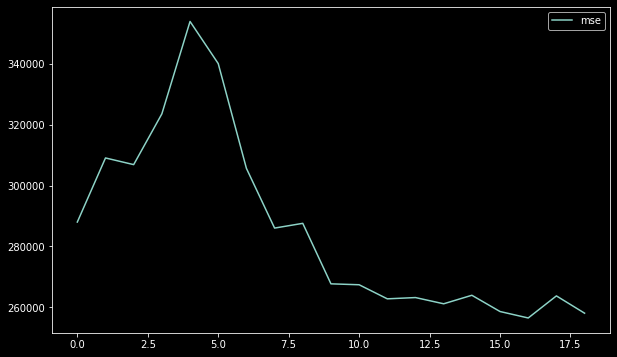

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.plot(hist.history["mse"][1:], label="mse");
axes.legend();

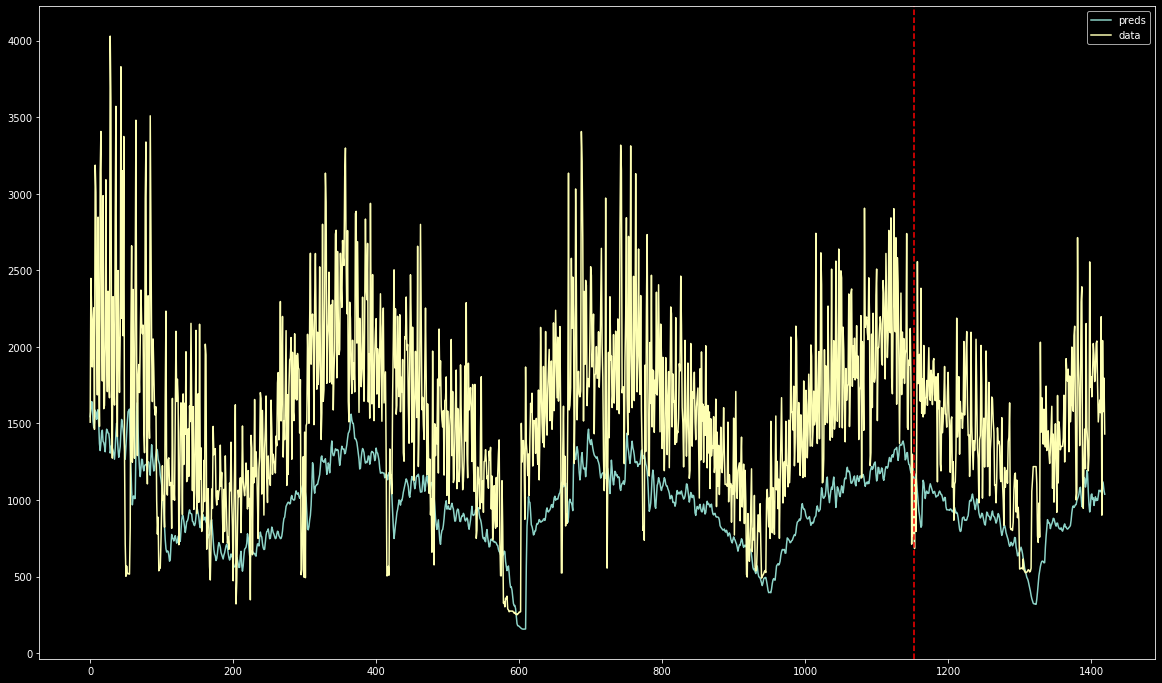

In [49]:
X, y = blocked_cv(data["Global_active_power"], window_size, h)
X = X[:, :, None]

preds = model.predict(X)

plt.subplots(figsize=(20, 12))
plt.plot(preds[:, -1], label="preds");
plt.plot(np.array(data["Global_active_power"].iloc[window_size + h - 1:]), label="data");
plt.legend();
plt.axvline(x=len(data) - test_size, c="red", ls="--");

In [42]:
history = [x for x in data_tr]
predictions = list()
for i in range(len(data_te)):
    df = np.array(history)
    # df = df.reshape((df.shape[0]*df.shape[1], df.shape[2]))
    input_x = df[-window_size:]
    input_x = input_x.reshape((1, len(input_x), 1))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    predictions.append(yhat)
    history.append(data_te.iloc[i])
predictions = np.array(predictions)

scores = list()
for i in range(len(data_te)):
    mse = mean_squared_error(data_te.iloc([i], predictions[:, i])
    rmse = math.sqrt(mse)
    scores.append(rmse)
s = 0
for row in range(data_te[:, :, 0].shape[0]):
    for col in range(data_te[:, :, 0].shape[1]):
        s += (data_te[:, :, 0][row, col] - predictions[row, col])**2
score = math.sqrt(s / (data_te[:, :, 0].shape[0] * data_te[:, :, 0].shape[1]))


s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % ("lstm", score, s_scores))
    
days = ["sun", "mon", "tue", "wed", "thr", "fri", "sat"]
plt.plot(days, scores, marker="o", label="lstm");

KeyboardInterrupt: ignored